In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Mar 23 19:45:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install transformers
!pip install spacy 
!pip install sentencepiece
!pip install langdetect
!pip install pytorch-lightning
!pip install fasttext
!pip3 uninstall googletrans
!pip install google_trans_new
!pip install dl-translate

     |████████████████████████████████| 2.0MB 5.5MB/s 
     |████████████████████████████████| 3.2MB 21.5MB/s 
     |████████████████████████████████| 890kB 33.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=98926a388da0ddc5394c10916ee9d5e34104f234a301fb6ad3ab638fe65b80a1
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 5.9MB/s 
     |████████████████████████████████| 983kB 4.5MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=e5b3a812d70028eb1e76219b4f7b6fddf49219c235b1b7597a087f85fc12424a
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect
     |████████████████████████████████| 829kB 4.4MB/s 
     |████████████████████████████████| 112kB 13.1MB/s 
     |███████████

In [6]:
import numpy as np
import pandas as pd
import fnmatch
import os
import fasttext
import random
import re
import threading
import librosa,librosa.display
import tensorflow as tf
from six.moves import xrange
import time
import json
import torch as t
import tqdm
import soundfile
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.distributed import DistributedSampler
from time import sleep
import torch.nn as nn
import torch.nn.functional as F
import math
import pickle
import functools
import sentencepiece
from google_trans_new import google_translator  
from sklearn.model_selection import train_test_split

In [7]:
translator = google_translator()  

In [8]:
eval_path = '/content/drive/MyDrive/Inter-IIT/All/evaluation_data.xlsx'

## **Data-processing**

In [9]:
df_all = pd.DataFrame(pd.read_excel(eval_path)) 

In [10]:
df_all

,Text_ID,Text
0,article_4001,Market Highlights\n\nAn automotive constant ve...
1,article_4002,Overview:\n\nBe it as a means for food or as p...
2,article_4003,"GenScript USA Inc. (U.S.), Horizon Discovery G..."
3,article_4004,New Delhi: Prime Minister Narendra Modi spoke ...
4,article_4005,"New Delhi, Feb 1 (PTI) The Delhi High Court Mo..."
...,...,...
427,tweet_4206,#ios 6.1 #for #iphone #very #bad and #iPhone5 ...
428,tweet_4207,One #bad thing of #XiaomiRedmiNote4 is the au...
429,tweet_4208,I have a concern over the service provided . ...
430,tweet_4209,#Bought Nokia6.1Plus in Oct2018 and having wor...


In [11]:
# function to preprocess speech
def clean(text):
    
    # removing paragraph numbers
    text = re.sub('[0-9]+.\t','',str(text))
    # removing new line characters
    text = re.sub('\n ','',str(text))
    text = re.sub('\n',' ',str(text))
    # removing apostrophes
    text = re.sub("'s",'',str(text))
    # removing hyphens
    text = re.sub("-",' ',str(text))
    text = re.sub("— ",'',str(text))
    # removing quotation marks
    text = re.sub('\"','',str(text))
    # removing salutations
    text = re.sub("Mr\.",'Mr',str(text))
    text = re.sub("Mrs\.",'Mrs',str(text))
    # removing any reference to outside text
    text = re.sub("[\(\[].*?[\)\]]", "", str(text))
    
    return text

# preprocessing speeches
df_all['Text'] = df_all['Text'].apply(clean)


In [13]:
class LanguageIdentification:

    def __init__(self):
        PRETRAINED_MODEL_PATH = '/content/drive/MyDrive/Inter-IIT/All/Fasttext/lid.176.bin'
        self.model = fasttext.load_model(PRETRAINED_MODEL_PATH)

    def predict_lang(self, text):
        predictions = self.model.predict(text,k = 1) # returns top 2 matching languages
        return predictions

LANGUAGE = LanguageIdentification()

In [14]:
headline_lang = []

for head in df_all.Text:
    if(LANGUAGE.predict_lang(head)[0][0].split('_')[-1] == 'en' and LANGUAGE.predict_lang(head)[1][0] > 0.5):
        headline_lang.append('English')
    elif(LANGUAGE.predict_lang(head)[0][0].split('_')[-1] == 'hi' and LANGUAGE.predict_lang(head)[1][0] > 0.5):
        headline_lang.append('Hindi')
    else:
        headline_lang.append('Mix')

In [15]:
df_all['Headline_lang'] = headline_lang

In [16]:
df_all

,Text_ID,Text,Headline_lang
0,article_4001,Market Highlights An automotive constant velo...,English
1,article_4002,Overview: Be it as a means for food or as pet...,English
2,article_4003,"GenScript USA Inc. , Horizon Discovery Group p...",English
3,article_4004,New Delhi: Prime Minister Narendra Modi spoke ...,English
4,article_4005,"New Delhi, Feb 1 The Delhi High Court Monday ...",English
...,...,...,...
427,tweet_4206,#ios 6.1 #for #iphone #very #bad and #iPhone5 ...,English
428,tweet_4207,One #bad thing of #XiaomiRedmiNote4 is the au...,English
429,tweet_4208,I have a concern over the service provided . ...,English
430,tweet_4209,#Bought Nokia6.1Plus in Oct2018 and having wor...,English


In [17]:
df_all[df_all['Headline_lang'] == 'Mix']

,Text_ID,Text,Headline_lang
61,article_4063,"L R: Amad Diallo, Morgan Sanson and Said Benra...",Mix
201,article_4204,Mobile Phone Ka Pata Kaise Lagaye Google Par –...,Mix
202,article_4205,Mobile se Blog Post Kaise Publish kare Novemb...,Mix
204,article_4207,"Blog Banane Ke Baad Kya Kya Kare January 14, ...",Mix
205,article_4208,Blog Kaise Banaye Step by Step in Hindi May 2...,Mix
...,...,...,...
420,tweet_4199,Oppo Reno5 Pro+ 5G चीन में लॉन्च कर दिया है| #...,Mix
423,tweet_4202,THE WORST THING NOW #mobile #phone #bad #signa...,Mix
424,tweet_4203,#Samsung HATE SAMSUNG AND ITS RIDICULOUS AND H...,Mix
425,tweet_4204,I hate @BlackBerryits so #waste #suggest not ...,Mix


# **XLM-Roberta-test**

In [18]:
from transformers import XLMRobertaTokenizer

tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

##Articles

In [19]:
# Main Tokenization here 
input_ids = []
lengths = []

print('Tokenizing comments.....')

for sen in df_all.Text:

    if(len(input_ids) % 1000 == 0):
      print(f'Read about {len(input_ids)} article!')
    

    encoded_sent = tokenizer.encode(
                            sen,
                            # max_length = 512,
                            # return_tensors = 'pt'   
                            )
    
    input_ids.append(encoded_sent)
    lengths.append(len(encoded_sent))

print('Done!')

Token indices sequence length is longer than the specified maximum sequence length for this model (1233 > 512). Running this sequence through the model will result in indexing errors


Tokenizing comments.....
Read about 0 article!
Done!


In [20]:
# input_ids[0][:512]

In [21]:
print(f'Min length of tokens : {min(lengths)}')
print(f'Max length of tokens : {max(lengths)}')
print(f'Mean length of tokens : {np.mean(lengths)}')

Min length of tokens : 19
Max length of tokens : 8915
Mean length of tokens : 548.1296296296297


In [22]:
temp = []

for i in lengths:
    if(i > 833):
        temp.append(i)
print(len(temp))

84


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


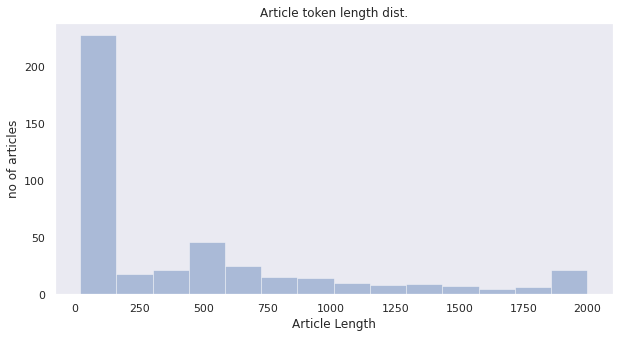

In [23]:
#Plotting the data for knowing distributions of length if tokens!
import seaborn as sns

sns.set(style = 'dark')
plt.rcParams["figure.figsize"] = (10,5)
new_lengths = [min(l,2000) for l in lengths]

sns.distplot(new_lengths,kde=False)

plt.title('Article token length dist.')
plt.xlabel('Article Length')
plt.ylabel('no of articles')
plt.show()

#Classification-XLMR

##Loading pretrained model

In [24]:
import torch

In [25]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [26]:
from transformers import XLMRobertaForSequenceClassification, AdamW, XLMRobertaConfig

model = XLMRobertaForSequenceClassification.from_pretrained(
        "xlm-roberta-base",
        num_labels = 2,
        output_attentions = False,
        output_hidden_states = False,
)

model.cuda()

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [28]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Inter-IIT/All/Checkpoint_classification /article(chunked)+tweets_model_no_dups (1).bin'))

<All keys matched successfully>

In [29]:
# Truncating to 512 for now (other wise use chunking for giving sentence length)

from keras.preprocessing.sequence import  pad_sequences

MAX_LEN = 512

input_ids = pad_sequences(input_ids, maxlen = MAX_LEN, dtype = "long", value=0, 
                          truncating="post", padding="post")


##Articles continued

In [30]:
input_ids.shape

(432, 512)

In [31]:


# Attention Mask
attention_masks = []

for sent in input_ids:
    # set mask to 0 if token_id is 0 (becoz its padding) and vice versa
    attn_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(attn_mask)


In [32]:
val_inputs = input_ids
val_masks = attention_masks

In [33]:

val_inputs = t.tensor(val_inputs)

val_masks = t.tensor(val_masks)


In [34]:
print(val_inputs.shape,val_masks.shape)

torch.Size([432, 512]) torch.Size([432, 512])


In [35]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 80

val_data = TensorDataset(val_inputs, val_masks)
#val_sampler = RandomSampler(val_data)
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle=False)

In [36]:
from tqdm import tqdm

In [37]:
# printing a classification report 

model.eval()
y_pred = []

for batch in tqdm(val_loader):
    input_ids = batch[0].to(device)    # The main training data
    attention_mask = batch[1].to(device)  # The input masks for padding
    with t.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    # print(logits.shape)
    pred_flat = np.argmax(logits, axis = 1).flatten()
    
    y_pred.append(pred_flat)

    

100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


In [38]:
y_pred_unrolled = []
for elem in y_pred:
  #print(elem)
  y_pred_unrolled.extend(elem)

### **Adding the Mobile_Tech_Flag_Predicted column to articles**

In [39]:
df_all['Mobile_Tech_Flag_Predicted'] =  y_pred_unrolled

In [40]:
df_all

,Text_ID,Text,Headline_lang,Mobile_Tech_Flag_Predicted
0,article_4001,Market Highlights An automotive constant velo...,English,0
1,article_4002,Overview: Be it as a means for food or as pet...,English,0
2,article_4003,"GenScript USA Inc. , Horizon Discovery Group p...",English,0
3,article_4004,New Delhi: Prime Minister Narendra Modi spoke ...,English,0
4,article_4005,"New Delhi, Feb 1 The Delhi High Court Monday ...",English,0
...,...,...,...,...
427,tweet_4206,#ios 6.1 #for #iphone #very #bad and #iPhone5 ...,English,1
428,tweet_4207,One #bad thing of #XiaomiRedmiNote4 is the au...,English,1
429,tweet_4208,I have a concern over the service provided . ...,English,0
430,tweet_4209,#Bought Nokia6.1Plus in Oct2018 and having wor...,English,1


# **Headline-Generation-T5**

In [41]:
df_all.shape

(432, 4)

In [42]:
df_all.columns

Index(['Text_ID', 'Text', 'Headline_lang', 'Mobile_Tech_Flag_Predicted'], dtype='object')

In [43]:
device = ('cuda' if t.cuda.is_available() else 'cpu')

In [44]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [45]:
from transformers import (
    AdamW,
    MT5ForConditionalGeneration,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

In [46]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [47]:
msk = np.random.rand(len(df_all)) < 0.8

## **T5-Model**

In [48]:
class MT5FineTuner(pl.LightningModule):
  def __init__(self, train_df, test_df, hparams):
    super(MT5FineTuner, self).__init__()
    self.hparams = hparams
    self.train_df = train_df
    self.test_df = test_df
    self.model = MT5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.global_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    print(outputs)
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None, on_tpu=False, using_native_amp=False, using_lbfgs=False):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, df=self.train_df, type_path="train", args=self.hparams)
    print(len(train_dataset))
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, df=self.test_df, type_path="val", args=self.hparams)
    print(len(val_dataset))
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

## **Data-preparation**

In [49]:
import dl_translate as dlt

mt = dlt.TranslationModel()  # Slow when you load it for the first time


In [51]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
import pickle
nltk.download('stopwords')

with open("/content/drive/MyDrive/Inter-IIT/All/Hinglish_dictionary/dictionary.pickle", "rb") as translit:
  translit_dic = pickle.load(translit)
  
def translit_text(text, translit_dic):

    english_stopwords_set = set(stopwords.words('english'))
    tokens = wordpunct_tokenize(text)
    words = [word.lower() for word in tokens]

    translit_text = ""

    for word in words:
        if word in english_stopwords_set:
            translit_text = translit_text + " " + word
        elif (word in translit_dic):
            translit_text = translit_text + " " + translit_dic[word]
        else:
            translit_text = translit_text + " " + word

    return translit_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
class HeadlineDataset(Dataset):
    def __init__(self, tokenizer, df, type_path, translit_dic, max_len=512, src = "Text", labels= "Mobile_Tech_Flag", t_id = "Text_ID", targ_lab= "Headline_lang" ):

        self.source_column = src
        self.target_label_column = targ_lab
        self.t_label = labels
        self.t_id = t_id
        self.data = df
        self.translit_dic = translit_dic
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.inputs = []
        self.t_lang = []
        self.tech_labels = []
        self.text_id = []

        self._build()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        source_ids = self.inputs[index]["input_ids"].squeeze()

        src_mask = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze


        return {"source_ids": source_ids, "source_mask": src_mask, "source_lang": self.t_lang[index], "tech_label": self.tech_labels[index], "text_id": self.text_id[index]} 

    def _build(self):
        for idx in range(len(self.data)):
            input_, target_lan, label, t_id = self.data.loc[idx, self.source_column],  self.data.loc[idx, self.target_label_column],\
                                                                    self.data.loc[idx, self.t_label], self.data.loc[idx, self.t_id]  
            self.t_lang.append(target_lan)
            self.tech_labels.append(label)
            self.text_id.append(t_id)

            if target_lan == 'Mix':
              input_ = translit_text(input_, self.translit_dic)

            input_h = 'English' + " Headline: "+ input_ + ' </s>'

            #print(input_h)
            # tokenize inpinput_huts
            tokenized_inputs = self.tokenizer.batch_encode_plus(
                [input_h], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
            )
            
            self.inputs.append(tokenized_inputs)

In [53]:
tokenizer_gen = T5Tokenizer.from_pretrained('google/mt5-small')

In [54]:
def get_dataset(tokenizer, df, type_path, args):
  return HeadlineDataset(tokenizer_gen = tokenizer_gen, tokenizer = tokenizer, df=df, type_path=type_path,  max_len=args.max_seq_length)

## **Pytorch-base**

In [55]:
save_model = True
load_model = True

In [56]:
model_gen = MT5ForConditionalGeneration.from_pretrained('google/mt5-small')
tokenizer_gen = T5Tokenizer.from_pretrained('google/mt5-small')

In [57]:
model_gen.cuda()

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedGeluDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (w

In [58]:
PATH = '/content/drive/My Drive/Inter-IIT/MT5'
checkpoint_path = '/content/drive/MyDrive/Inter-IIT/All/Checkpoint_headline/Copy of checkpoint_latest.pt'

In [59]:
if(load_model):
  checkpoint = torch.load(checkpoint_path)
  model_gen.load_state_dict(checkpoint['model_state_dict'])
  

##Evaluation (whole dataframe)

In [60]:
df_all

,Text_ID,Text,Headline_lang,Mobile_Tech_Flag_Predicted
0,article_4001,Market Highlights An automotive constant velo...,English,0
1,article_4002,Overview: Be it as a means for food or as pet...,English,0
2,article_4003,"GenScript USA Inc. , Horizon Discovery Group p...",English,0
3,article_4004,New Delhi: Prime Minister Narendra Modi spoke ...,English,0
4,article_4005,"New Delhi, Feb 1 The Delhi High Court Monday ...",English,0
...,...,...,...,...
427,tweet_4206,#ios 6.1 #for #iphone #very #bad and #iPhone5 ...,English,1
428,tweet_4207,One #bad thing of #XiaomiRedmiNote4 is the au...,English,1
429,tweet_4208,I have a concern over the service provided . ...,English,0
430,tweet_4209,#Bought Nokia6.1Plus in Oct2018 and having wor...,English,1


In [61]:
dataset = HeadlineDataset(tokenizer_gen, df_all, 'test', translit_dic,  max_len=512, labels = 'Mobile_Tech_Flag_Predicted')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:175: UserWarning: T

In [62]:
len(dataset)

432

In [63]:
batch_size = 80

In [64]:
test_loader = DataLoader(dataset, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=4)

In [65]:
from tqdm import tqdm

In [66]:
headlines = []


for step, batch in enumerate(tqdm(test_loader)):#for i in trange(100):

  input_ids = batch["source_ids"].numpy()
  attention_masks = batch["source_mask"].numpy()

  gen_batch = np.sum(batch['tech_label'].numpy())
  if gen_batch == 0:
    for i in range(input_ids.shape[0]):
      headlines.append('')
    continue
  new_input_ids_gen = np.zeros((gen_batch, 512))
  new_attention_masks_gen = np.zeros((gen_batch, 512))

  indd = 0
  tech_flags = []
  for i, tech_l in enumerate(batch['tech_label'].numpy()):
    if tech_l == 1:
      new_input_ids_gen[indd] = input_ids[i]
      new_attention_masks_gen[indd] = attention_masks[i]
      tech_flags.append(i)
      indd += 1

  new_input_ids_gen = t.tensor(new_input_ids_gen).type(t.LongTensor).cuda()
  new_attention_masks_gen = t.tensor(new_attention_masks_gen).type(t.LongTensor).cuda()

  #print(new_input_ids_gen)

  beam_outputs = model_gen.generate(
                input_ids = new_input_ids_gen,
                attention_mask = new_attention_masks_gen,
                max_length = 64,
                top_k=120,
                top_p=0.92,
                early_stopping =  True,
                )
  
  #print(beam_outputs.shape[0] == len(tech_flags))

  indd = 0
  for i in range(input_ids.shape[0]):
    if i in tech_flags:
      result = tokenizer_gen.decode(beam_outputs[indd], skip_special_tokens=True,clean_up_tokenization_spaces=True)
      indd += 1
      #For Hindi
      if not(LANGUAGE.predict_lang(result)[0][0].split('_')[-1] == 'en' and LANGUAGE.predict_lang(result)[1][0] > 0.5):
        text_hi = result
        result = mt.translate(text_hi, source=dlt.lang.HINDI, target=dlt.lang.ENGLISH)

      headlines.append(result)
    else:
      headlines.append('')



100%|██████████| 6/6 [00:59<00:00, 10.00s/it]


In [67]:
len(headlines)

432

In [68]:
headlines[-1000:]

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'HP Inc. Names Jami Miscik to Board of Directors',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Latest News\\n Complaints in the action of cyber cells, whenever there is a complaint',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'iOS 14.5 Will Let iPhone Users Unlock Smartphone Directly via Apple Watch Even While Wearing a Mask',
 'Poco M3 with Snapdrago

In [69]:
df_all

,Text_ID,Text,Headline_lang,Mobile_Tech_Flag_Predicted
0,article_4001,Market Highlights An automotive constant velo...,English,0
1,article_4002,Overview: Be it as a means for food or as pet...,English,0
2,article_4003,"GenScript USA Inc. , Horizon Discovery Group p...",English,0
3,article_4004,New Delhi: Prime Minister Narendra Modi spoke ...,English,0
4,article_4005,"New Delhi, Feb 1 The Delhi High Court Monday ...",English,0
...,...,...,...,...
427,tweet_4206,#ios 6.1 #for #iphone #very #bad and #iPhone5 ...,English,1
428,tweet_4207,One #bad thing of #XiaomiRedmiNote4 is the au...,English,1
429,tweet_4208,I have a concern over the service provided . ...,English,0
430,tweet_4209,#Bought Nokia6.1Plus in Oct2018 and having wor...,English,1


In [70]:
df_all = df_all.drop(['Text','Headline_lang'],axis = 1)

In [71]:
df_all['Headline_Generated_Eng_Lang'] = headlines 

In [72]:
df_all.columns

Index(['Text_ID', 'Mobile_Tech_Flag_Predicted', 'Headline_Generated_Eng_Lang'], dtype='object')

In [73]:
df_all = df_all[['Text_ID','Mobile_Tech_Flag_Predicted','Headline_Generated_Eng_Lang']]

In [74]:
# df_art.values[3995]

In [75]:
df_all.shape

(432, 3)

In [76]:
df_all

,Text_ID,Mobile_Tech_Flag_Predicted,Headline_Generated_Eng_Lang
0,article_4001,0,
1,article_4002,0,
2,article_4003,0,
3,article_4004,0,
4,article_4005,0,
...,...,...,...
427,tweet_4206,1,"Nokia launched Samsung Galaxy A71, how to know..."
428,tweet_4207,1,Xiaomu Redmi Note4 vs Redmi Note4: It's all ri...
429,tweet_4208,0,
430,tweet_4209,1,Nokia smartphones imminent as a new Nokia smar...


In [ ]:
# saving the dataframe 
df_all.to_csv('/content/drive/MyDrive/inter-iit/output1.csv', index = False) 